# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls


In [61]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


In [26]:
df_motorbike_amb_calls = pd.read_csv('motorbike_ambulance_calls.csv')

df_motorbike_amb_calls.head()

,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1/1/11,spring,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,1/1/11,spring,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,1/1/11,spring,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,1/1/11,spring,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,1/1/11,spring,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [27]:
print('Shape:',df_motorbike_amb_calls.shape)
print('Size:',df_motorbike_amb_calls.size)

Shape: (17379, 15)
Size: 260685


In [28]:
df_motorbike_amb_calls.isnull().sum()

index         0
date          0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

In [29]:
print(df_motorbike_amb_calls.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       17379 non-null  int64  
 1   date        17379 non-null  object 
 2   season      17379 non-null  object 
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9), object(2)
memory usage: 2.0+ MB
None


In [30]:
df_motorbike_amb_calls = df_motorbike_amb_calls.drop_duplicates()

We performed basic data analysis. Additionally, we analyzed missing values and removed duplicates.

In [31]:
df_motorbike_amb_calls["season"].unique()

df_motorbike_amb_calls["date"] = pd.to_datetime(df_motorbike_amb_calls["date"])
df_motorbike_amb_calls["date"]

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
17374   2012-12-31
17375   2012-12-31
17376   2012-12-31
17377   2012-12-31
17378   2012-12-31
Name: date, Length: 17379, dtype: datetime64[ns]

In [32]:
def get_season(date):
    if date.month in (3, 4, 5): 
        return 1
    elif date.month in (6, 7, 8): 
        return 2
    elif date.month in (9, 10, 11): 
        return 3
    else: 
        return 0

df_motorbike_amb_calls["season"] = df_motorbike_amb_calls["date"].apply(get_season)
df_motorbike_amb_calls.sample(10)


,index,date,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
7293,7294,2011-11-05,3,0,11,12,0,6,0,1,0.36,0.3485,0.46,0.1642,372
2138,2139,2011-04-03,1,0,4,23,0,0,0,1,0.40,0.4091,0.50,0.0896,31
16504,16505,2012-11-25,3,1,11,10,0,0,0,1,0.24,0.2273,0.48,0.2537,139
5249,5250,2011-08-11,2,0,8,15,0,4,1,1,0.80,0.6970,0.29,0.2985,178
16580,16581,2012-11-28,3,1,11,14,0,3,1,1,0.36,0.3333,0.40,0.2985,176
11366,11367,2012-04-23,1,1,4,19,0,1,1,2,0.34,0.3182,0.76,0.2239,298
3384,3385,2011-05-25,1,0,5,22,0,3,1,1,0.66,0.6212,0.69,0.2537,174
10083,10084,2012-03-01,1,1,3,5,0,4,1,1,0.48,0.4697,0.88,0.1642,18
10511,10512,2012-03-19,1,1,3,2,0,1,1,1,0.46,0.4545,0.88,0.1642,8
3479,3480,2011-05-29,1,0,5,21,0,0,0,1,0.68,0.6364,0.83,0.1642,229


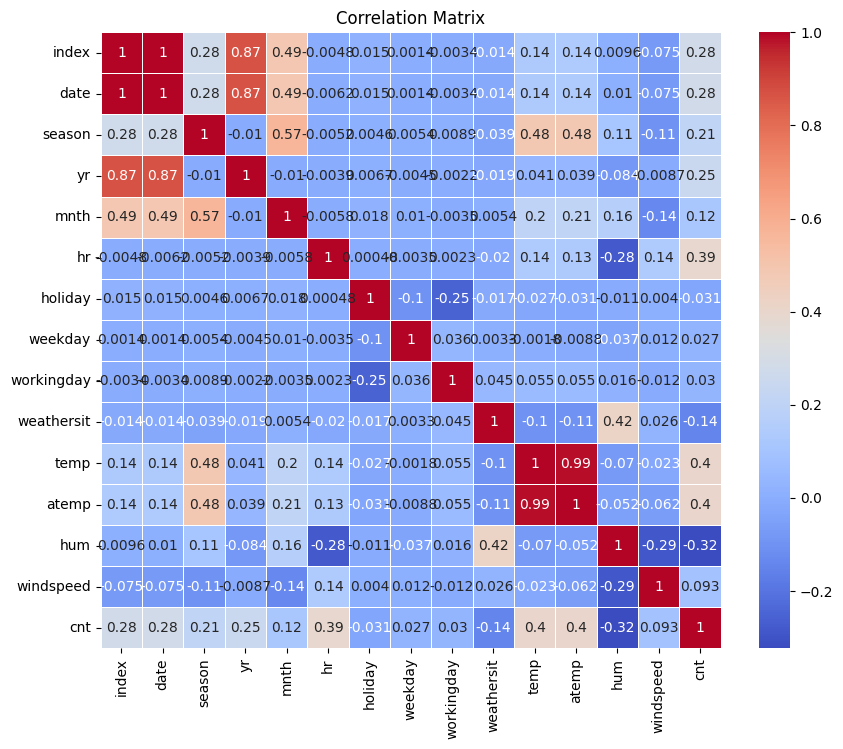

In [33]:
corr_matrix = df_motorbike_amb_calls.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix reveals that some variables, such as `hum`, `windspeed`, and `weathersit`, have slight correlations with each other. Notably, `temp` and `atemp` are completely multicollinear, so one of them can be dropped. Additionally, there is a significant correlation between the target variable `cnt` and features like `temp` and `hum`, indicating a relationship between weather conditions and ambulance calls.

In [41]:
df_motorbike_amb_calls.drop(columns=["atemp"], inplace=True)


This column is useless so I am dropping it

In [47]:
categorical_columns = df_motorbike_amb_calls.select_dtypes(include='int').columns
categorical_columns = categorical_columns[1:len(categorical_columns) - 1]
categorical_columns

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit'],
      dtype='object')

In [45]:
numerical_columns = df_motorbike_amb_calls.loc[:, ["temp", "hum", "windspeed"]]
display(numerical_columns)

,temp,hum,windspeed
0,0.24,0.81,0.0000
1,0.22,0.80,0.0000
2,0.22,0.80,0.0000
3,0.24,0.75,0.0000
4,0.24,0.75,0.0000
...,...,...,...
17374,0.26,0.60,0.1642
17375,0.26,0.60,0.1642
17376,0.26,0.60,0.1642
17377,0.26,0.56,0.1343


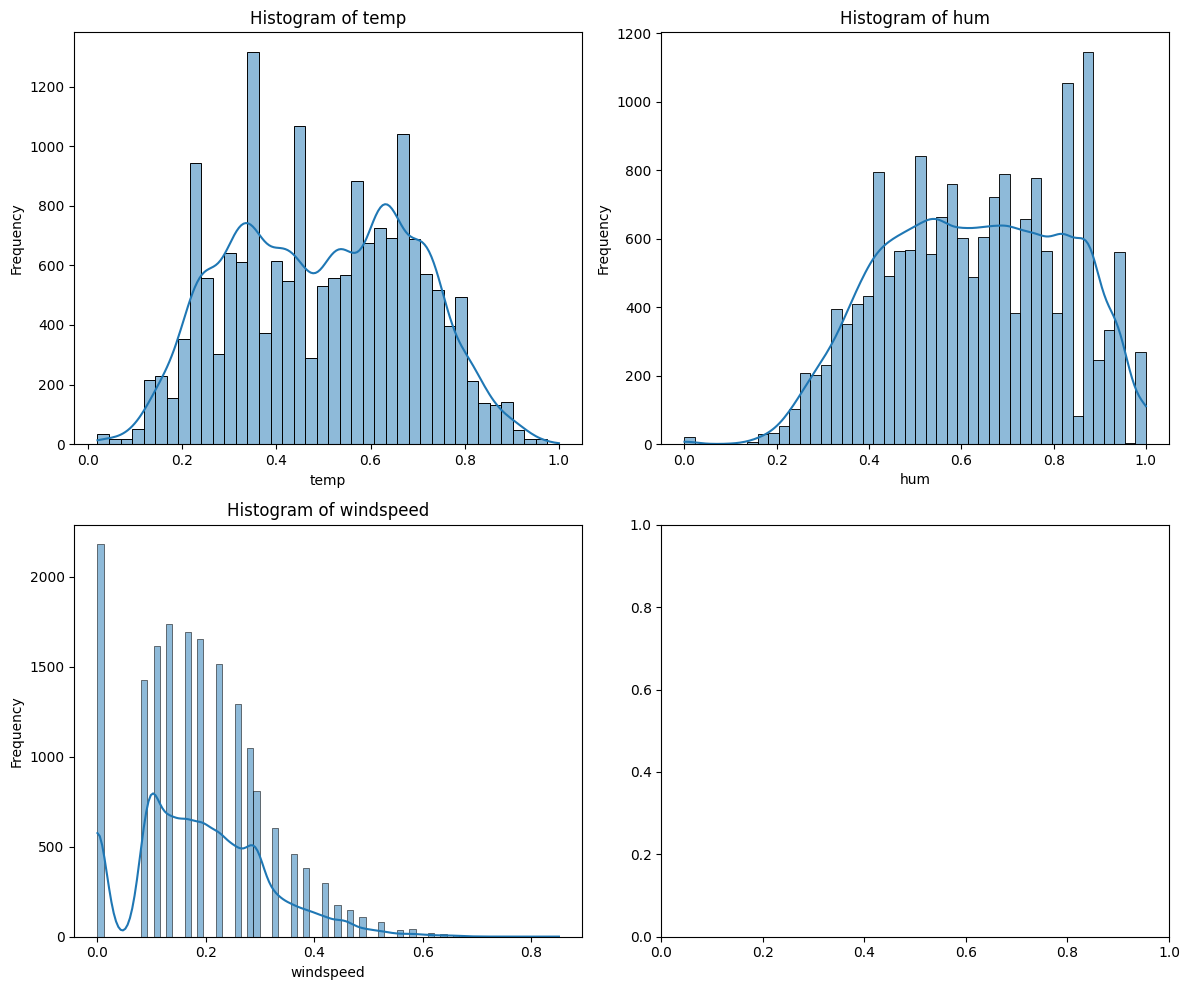

In [46]:
num_rows = 2
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 10))

axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(df_motorbike_amb_calls[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


The `temperature` variable shows a bimodal distribution, with several peaks, suggesting clusters of values. 

The `humidity` histogram has a heavy right tail, indicating positive skewness, meaning high humidity is more common during ambulance calls. 

The `windspeed` histogram also shows positive skewness with most values concentrated in the lower range, suggesting that most calls occur during low wind conditions. 


Index(['index', 'date', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt'],
      dtype='object')


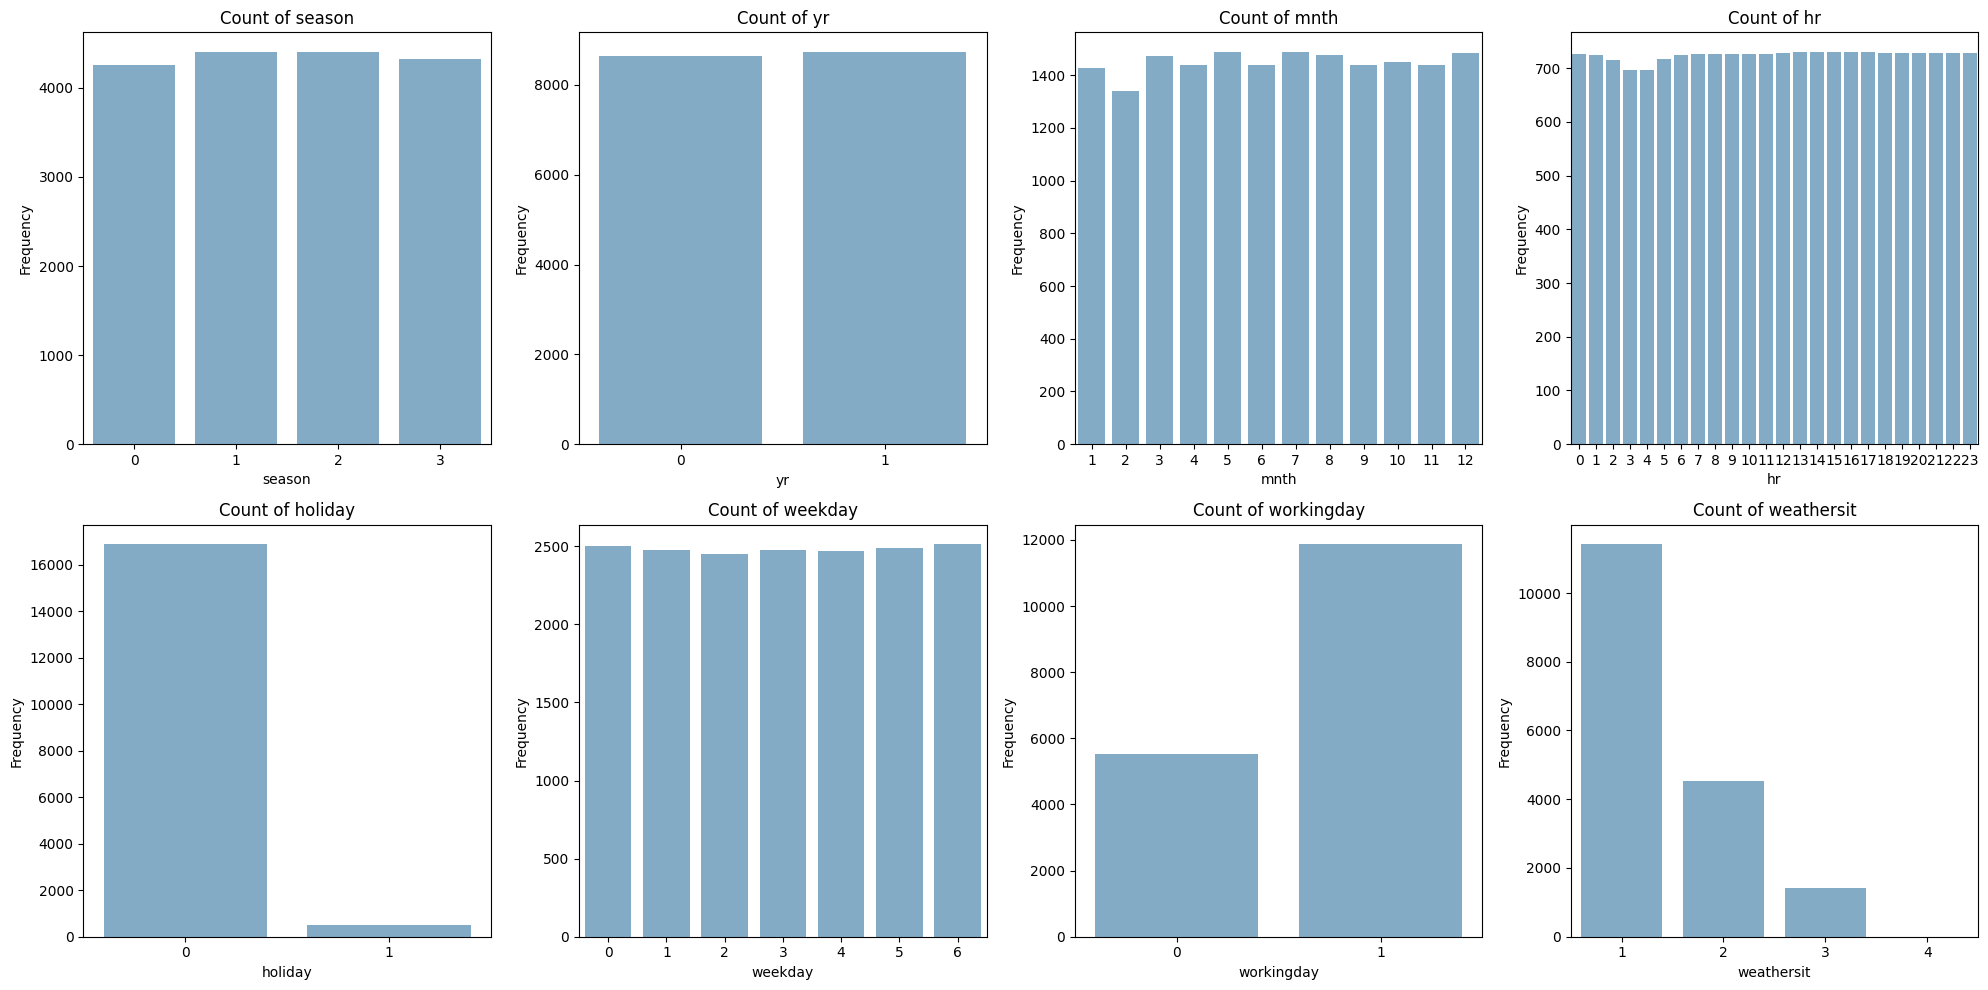

In [48]:

print(df_motorbike_amb_calls.columns)

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    if col in df_motorbike_amb_calls.columns: 
        sns.countplot(data=df_motorbike_amb_calls, x=col, ax=axes[i], alpha=0.6)
        axes[i].set_title(f'Count of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



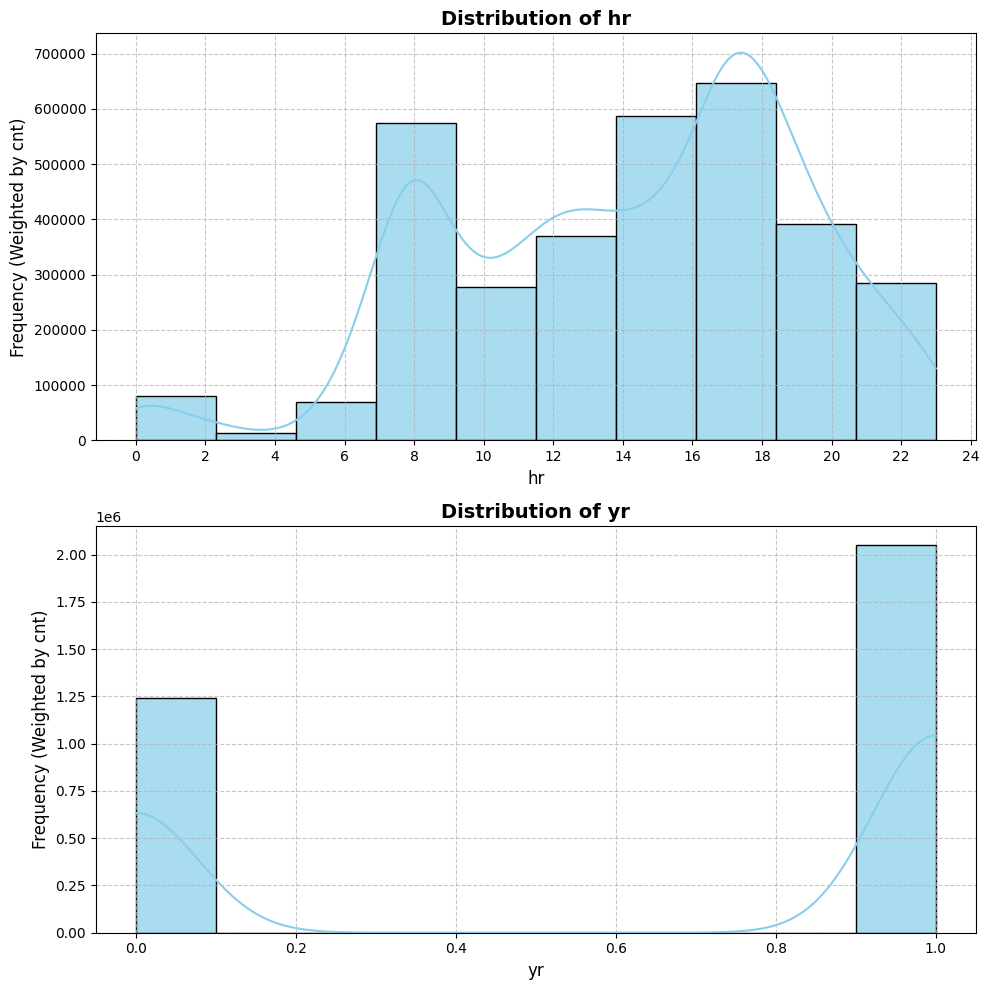

In [51]:

variables_to_target = ["hr", "yr"]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

for i in range(len(variables_to_target)):
    sns.histplot(data=df_motorbike_amb_calls, x=variables_to_target[i], weights="cnt", ax=ax[i], kde=True, color="skyblue", alpha=0.7)

    ax[i].set_title(f"Distribution of {variables_to_target[i]}", fontsize=14, fontweight='bold')
    ax[i].set_xlabel(variables_to_target[i], fontsize=12)
    ax[i].set_ylabel('Frequency (Weighted by cnt)', fontsize=12)

    if variables_to_target[i] == "hr":
        ax[i].set_xticks(range(0, 25, 2))
        ax[i].set_xticklabels([str(x) for x in range(0, 25, 2)], fontsize=10)
    
    ax[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Here, we observe that the majority of ambulance calls occur between the hours of 7 AM and 11 PM. Additionally, there is a noticeable decrease in ambulance calls during 2011 compared to 2012, so we will separate the data into two groups based on the years.

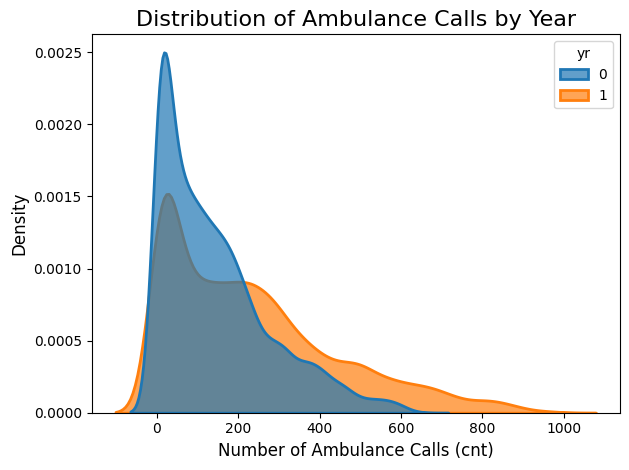

In [56]:

sns.kdeplot(data=df_motorbike_amb_calls, x='cnt', hue='yr', fill=True, linewidth=2, alpha=0.7)

plt.title('Distribution of Ambulance Calls by Year', fontsize=16)
plt.xlabel('Number of Ambulance Calls (cnt)', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.tight_layout()
plt.show()


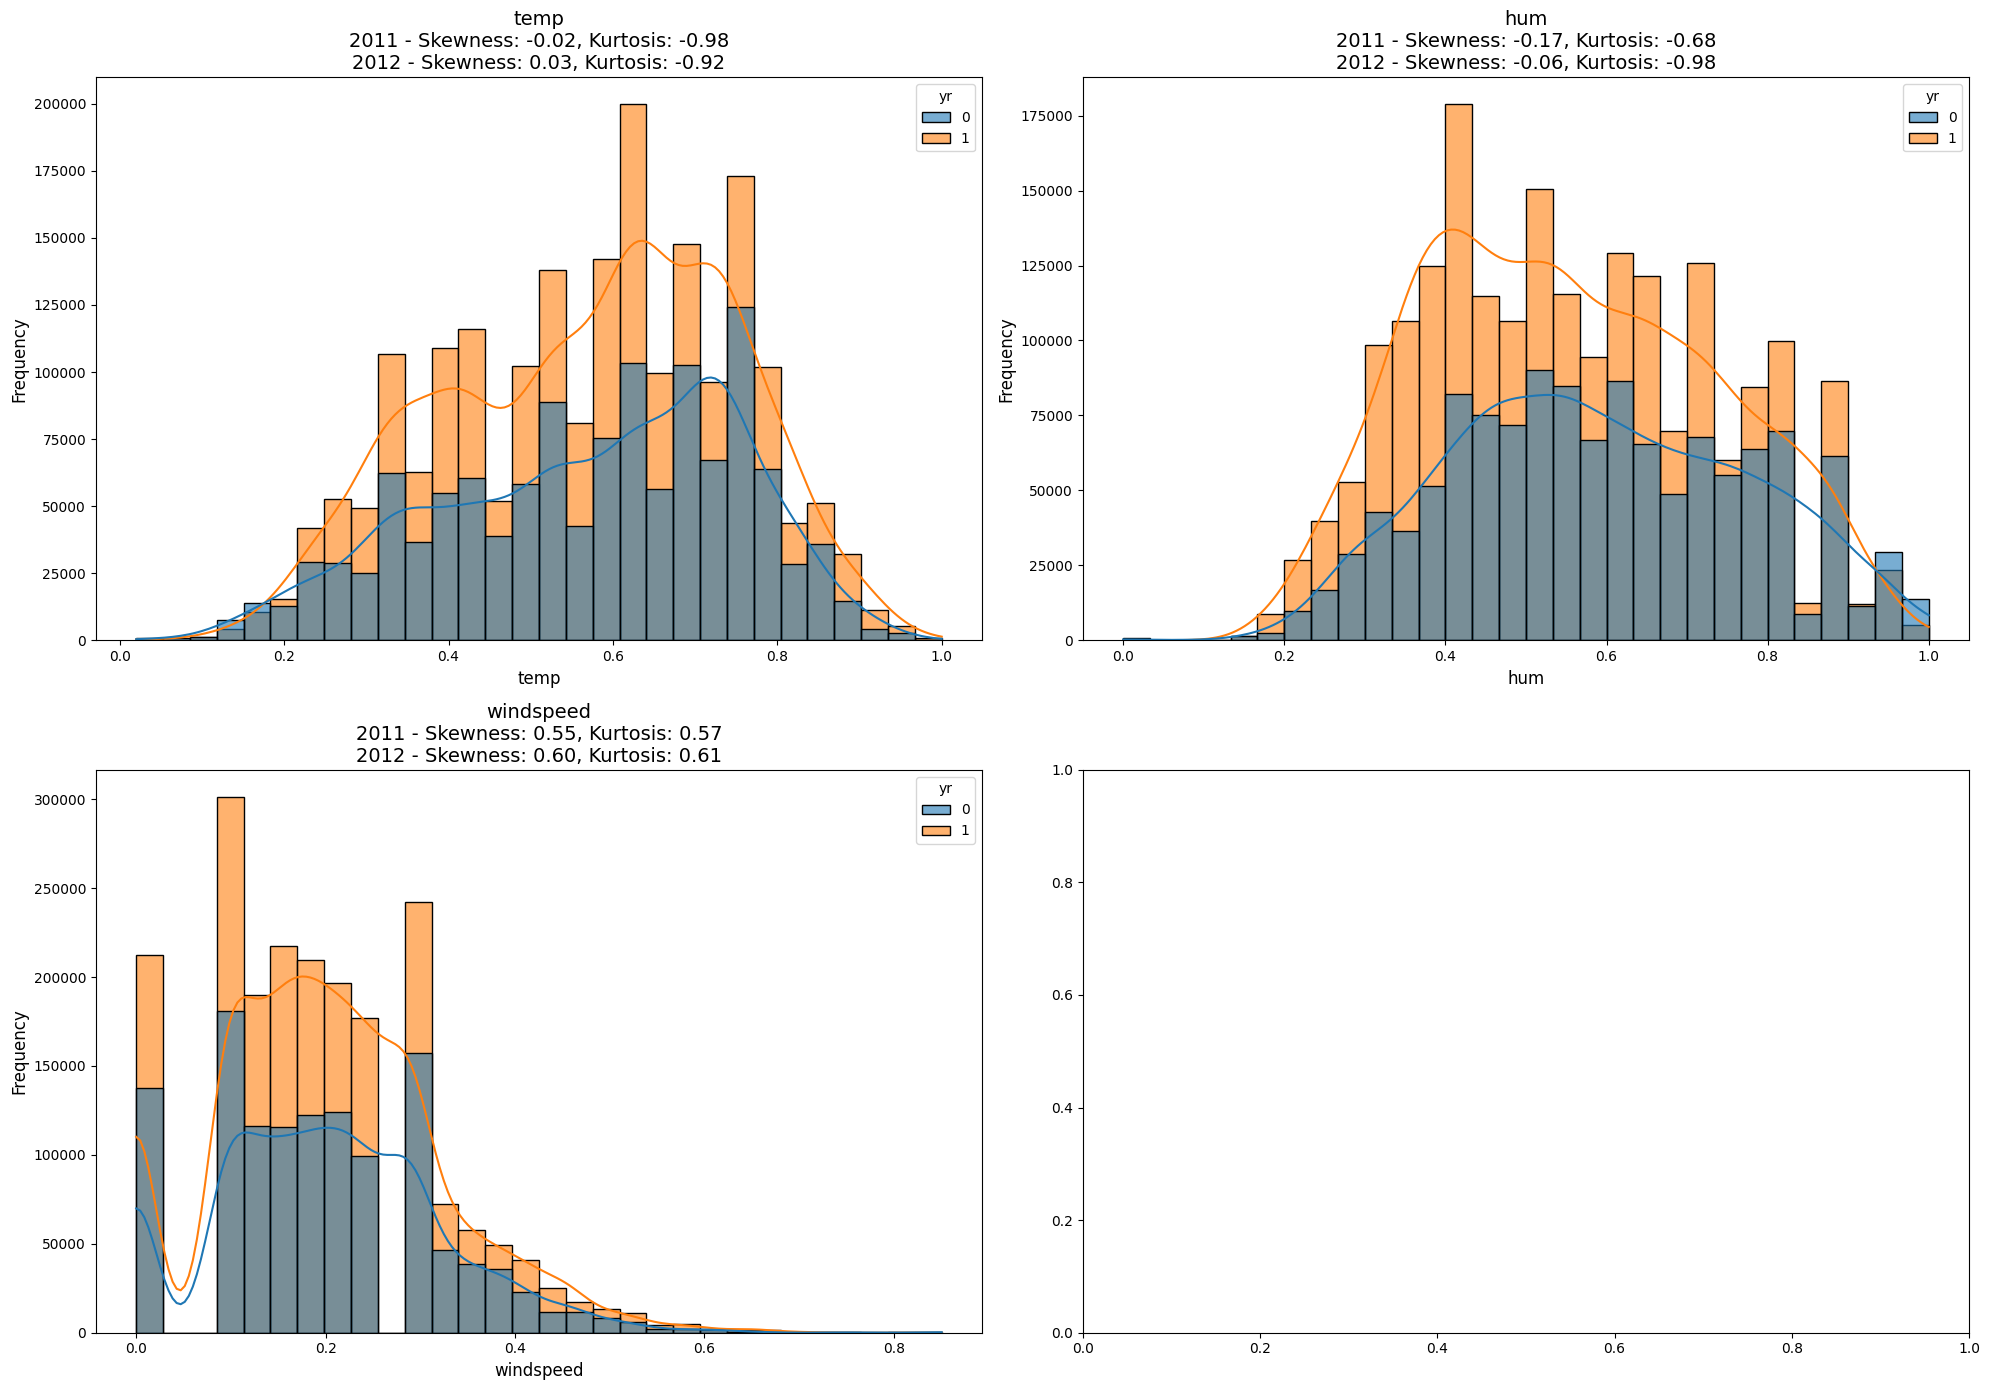

In [58]:

numerical_data = df_motorbike_amb_calls.loc[:, ["temp", "hum", "windspeed"]]

fig, ax = plt.subplots(2, 2, figsize=(20, 14))

for col, subplot in zip(numerical_data.columns, ax.flatten()):
    data_2011 = df_motorbike_amb_calls[df_motorbike_amb_calls["yr"] == 0][col]
    data_2012 = df_motorbike_amb_calls[df_motorbike_amb_calls["yr"] == 1][col]

    col_skewness_2011 = skew(data_2011, nan_policy='omit')
    col_skewness_2012 = skew(data_2012, nan_policy='omit')

    col_kurtosis_2011 = kurtosis(data_2011, nan_policy='omit')
    col_kurtosis_2012 = kurtosis(data_2012, nan_policy='omit')

    sns.histplot(data=df_motorbike_amb_calls, x=col, kde=True, weights="cnt", hue="yr", ax=subplot, bins=30, alpha=0.6)

    subplot.set_title(f"{col}\n2011 - Skewness: {col_skewness_2011:.2f}, Kurtosis: {col_kurtosis_2011:.2f}\n"
                      f"2012 - Skewness: {col_skewness_2012:.2f}, Kurtosis: {col_kurtosis_2012:.2f}",
                      fontsize=14)

    subplot.set_xlabel(col, fontsize=12)
    subplot.set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()


Based on the histograms and the calculated skewness and kurtosis for the two years, we can draw the following conclusions:

`Temperature`: This feature appears to be almost normally distributed, with very low skewness and kurtosis coefficients, indicating a near-zero asymmetry and a lack of heavy tails.
  
`Humidity`: In 2012, the distribution looks normal, but in 2011, we observe a skewness of -0.17 and a kurtosis of -0.68, indicating a longer tail to the left. From a real-life perspective, lower humidity means drier air, which is generally safer for weather conditions, but still, there was a significant number of calls on those days.

`Windspeed`: This feature has a long tail to the right, with skewness and kurtosis coefficients around 0.5 for both years, indicating a right-skewed distribution. This feature is even more interesting than humidity, as it shows a consistent pattern across both years.

In summary, `temp` is the most normally distributed, while `hum` and `windspeed` exhibit more complex distributions, with windspeed showing a pronounced right tail and humidity showing an unusual left tail in 2011.

# **Test**

In [81]:
from sklearn.preprocessing import StandardScaler


In [82]:
df_motorbike_amb_calls = df_motorbike_amb_calls.drop("date", axis=1)

scaler = StandardScaler()

X = df_motorbike_amb_calls.drop(["cnt"], axis=1)
y = df_motorbike_amb_calls["cnt"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgb_model = xgb.XGBRegressor(random_state=42)

param_grid_xgb = {
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5]
}

xgb_model_gs = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3)

xgb_model_gs.fit(X_train_scaled, y_train)

xgb_pred = xgb_model_gs.predict(X_test_scaled)

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print(f'XGBoost Mean Squared Error: {xgb_mse:.2f}')
print(f'XGBoost R^2 Score: {xgb_r2:.2f}')

print(f'Best Parameters: {xgb_model_gs.best_params_}')
print(f'Best Cross-validation Score: {xgb_model_gs.best_score_}')

KeyError: "['date'] not found in axis"

In [83]:
from scipy.stats import boxcox

Box-Cox lambda: 0.294


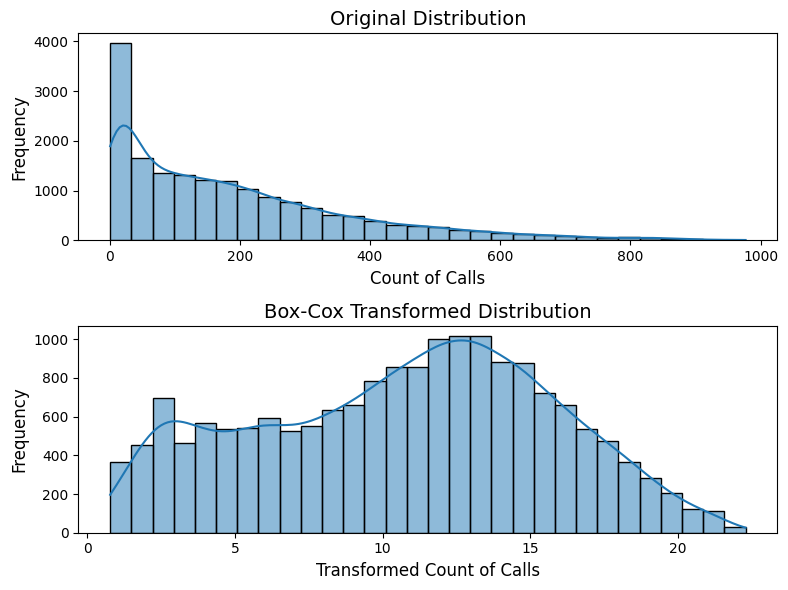

In [84]:
df_motorbike_amb_calls["cnt_boxcox"], lambda_boxcox = boxcox(df_motorbike_amb_calls["cnt"] + 1)

print(f"Box-Cox lambda: {lambda_boxcox:.3f}")

_, ax = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(df_motorbike_amb_calls["cnt"], kde=True, ax=ax[0], bins=30)
ax[0].set_title("Original Distribution", fontsize=14)
ax[0].set_xlabel("Count of Calls", fontsize=12)
ax[0].set_ylabel("Frequency", fontsize=12)

sns.histplot(df_motorbike_amb_calls["cnt_boxcox"], kde=True, ax=ax[1], bins=30)
ax[1].set_title("Box-Cox Transformed Distribution", fontsize=14)
ax[1].set_xlabel("Transformed Count of Calls", fontsize=12)
ax[1].set_ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

In [85]:
scaler = StandardScaler()

X = df_motorbike_amb_calls.drop(["cnt", "cnt_boxcox"], axis=1) 
y = df_motorbike_amb_calls["cnt_boxcox"]  

X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

In [86]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=3, 
    verbose=2, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

y_pred_rf = best_rf_model.predict(X_test)

y_pred_rf_inverse = np.exp(np.log(lambda_boxcox * y_pred_rf + 1) / lambda_boxcox)

y_test_inverse = np.exp(np.log(lambda_boxcox * y_test + 1) / lambda_boxcox)

rmse_rf = mean_squared_error(y_test_inverse, y_pred_rf_inverse, squared=False)
print(f"Random Forest RMSE with GridSearch: {rmse_rf:.3f}")

r2_rf = r2_score(y_test_inverse, y_pred_rf_inverse)
print(f"Random Forest R² with GridSearch: {r2_rf:.3f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Random Forest RMSE with GridSearch: 39.983
Random Forest R² with GridSearch: 0.950


The Random Forest model performs well with a low RMSE of 39.98, indicating that the average prediction error is relatively small. The R² score of 0.95 suggests that 95% of the variance in the target variable is explained by the model, which indicates strong predictive performance.

In [87]:
import lightgbm as lgb

In [88]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'random_state': 42
}

lgb_model = lgb.train(params, lgb_train, num_boost_round=100, valid_sets=[lgb_test])

y_pred_lgb = lgb_model.predict(X_test)

y_pred_lgb_inverse = np.exp(np.log(lambda_boxcox * y_pred_lgb + 1) / lambda_boxcox)

y_test_inverse = np.exp(np.log(lambda_boxcox * y_test + 1) / lambda_boxcox)

rmse_lgb = mean_squared_error(y_test_inverse, y_pred_lgb_inverse, squared=False)
print(f"\nLightGBM RMSE: {rmse_lgb:.3f}")

r2_lgb = r2_score(y_test_inverse, y_pred_lgb_inverse)
print(f"LightGBM R²: {r2_lgb:.3f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 482
[LightGBM] [Info] Number of data points in the train set: 13903, number of used features: 12
[LightGBM] [Info] Start training from score 10.702096

LightGBM RMSE: 40.002
LightGBM R²: 0.949


The LightGBM model achieved an RMSE of 40.002 and an R² of 0.949. This means that the model's predictions are reasonably accurate, with an error of about 40 units. The R² value of 0.949 indicates that the model explains 94.9% of the variance in the target variable, suggesting a very good fit to the data.

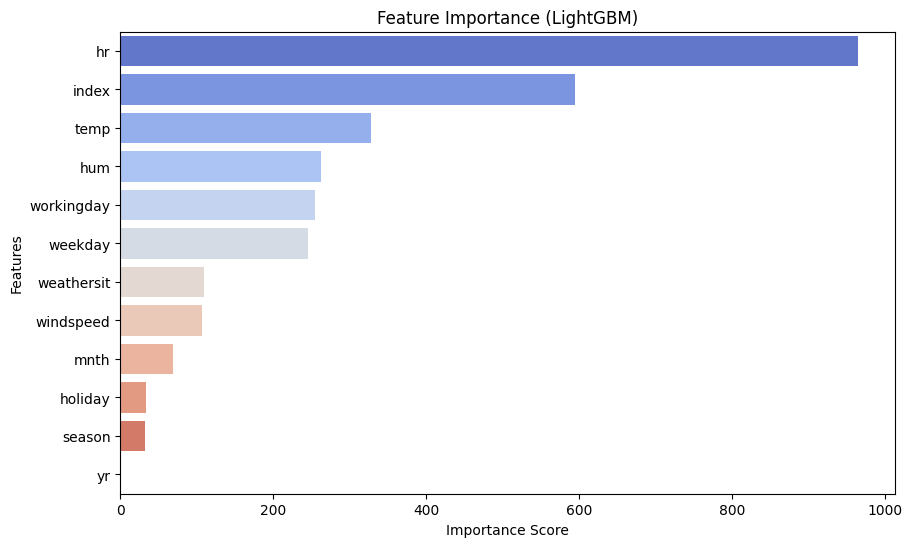

In [89]:
if hasattr(lgb_model, "feature_importance"):
    feature_importance = pd.Series(lgb_model.feature_importance(), index=X.columns).sort_values(ascending=False)
    
    if not feature_importance.empty:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="coolwarm")
        
        plt.title("Feature Importance (LightGBM)")
        plt.xlabel("Importance Score")
        plt.ylabel("Features")
        plt.show()
    else:
        print("Feature importance is empty.")
else:
    print("The model does not have the 'feature_importance' attribute. Ensure the model is trained.")

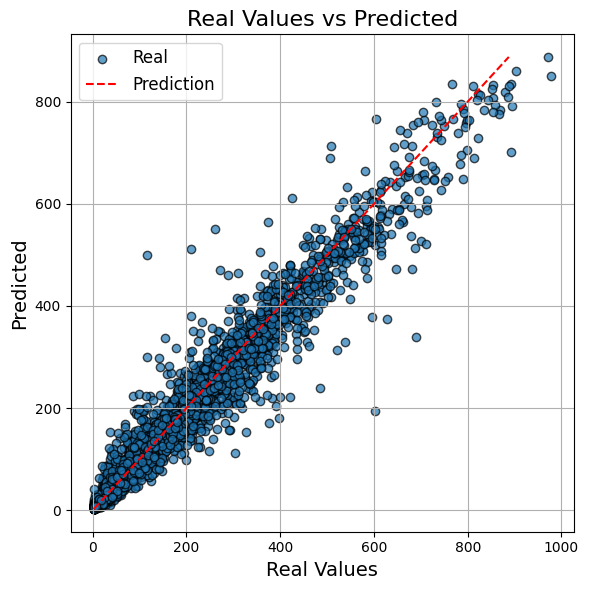

In [91]:
plt.figure(figsize=(6, 6))
plt.scatter(
    np.exp(np.log(lambda_boxcox * y_test + 1) / lambda_boxcox), 
    y_pred_lgb_inverse, 
    alpha=0.7, edgecolor='k', label='Real'
)
plt.plot(
    [min(y_pred_lgb_inverse), max(y_pred_lgb_inverse)], 
    [min(y_pred_lgb_inverse), max(y_pred_lgb_inverse)], 
    color='red', linestyle='--', label='Prediction'
)
plt.title('Real Values vs Predicted', fontsize=16)
plt.xlabel('Real Values', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()

pretty accurate